In [181]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy.typing import NDArray
from typing import TypeAlias

In [182]:
Vec3: TypeAlias = NDArray[np.float64]
Quat: TypeAlias = NDArray[np.float64]

EPS: float = 1e-12

In [183]:
# -----------------------------
# Paths
# -----------------------------
root: Path = Path.cwd().parent
run_dir: Path = root / "data" / "21:08_oct_07_2025_5min"

ori_path = run_dir / "Orientation.csv"
gyro_path = run_dir / "Gyroscope.csv"
grav_path = run_dir / "Gravity.csv"

for p in [ori_path, gyro_path, grav_path]:
        if not p.exists():
                raise FileNotFoundError(f"File not found: {p}")

In [184]:
# -----------------------------
# Quaternion lib
# -----------------------------
def quat_norm(q: Quat) -> Quat:
        n: float = np.sqrt(q[0]**2 + q[1]**2 + q[2]**2 + q[3]**2)
        if n > EPS:
                return q / n
        return np.array([1.0, 0.0, 0.0, 0.0], dtype=np.float64)

def quat_mul(q1: Quat, Q2: Quat) -> Quat:
        w1, x1, y1, z1 = q1
        w2, x2, y2, z2 = Q2
        return np.array(
                [
                        w1*w2 - x1*x2 - y1*y2 - z1*z2,
                        w1*x2 + x1*w2 + y1*z2 - z1*y2,
                        w1*y2 - x1*z2 + y1*w2 + z1*x2,
                        w1*z2 + x1*y2 - y1*x2 + z1*w2,
                ],
                dtype=np.float64)

def quat_conj(q: Quat) -> Quat:
        return np.array([q[0], -q[1], -q[2], -q[3]], dtype=np.float64)

def delta_quat_from_omega(omega: Vec3, dt: float) -> Quat:
        """
        Build incremental quaternion from angular velocity 𝜔[rad/s] and dt[s].
        Δq = [cos(θ/2), u⋅sin(θ/2)],
        θ = ||𝜔||⋅dt
        """
        mag: float = float(np.linalg.norm(omega))

        if mag < EPS or dt <= 0.0:
                return (np.array([1.0, 0.0, 0.0, 0.0], dtype=np.float64))

        theta: float = mag * dt
        u: Vec3 = omega / mag
        half: float = theta * 0.5
        return np.array(
                [np.cos(half), u[0]*np.sin(half), u[1]*np.sin(half), u[2]*np.sin(half)],
                dtype=np.float64)

def rotate_world_to_body(q, v_world):
    # v_body = q^{-1} (0,v) q  (q: body->world 라고 가정할 때)
    # 네 convention이 반대면 q (0,v) q^{-1}가 맞을 수 있음.
    vq = np.array([0.0, v_world[0], v_world[1], v_world[2]], dtype=np.float64)
    return quat_mul(quat_mul(quat_conj(q), vq), q)[1:]

In [185]:
# -----------------------------
# 1) Load Orientation — ref (qz, qy, qx, qw order in csv file)
# -----------------------------
ori_cols: list[str] = ["seconds_elapsed", "qw", "qx", "qy", "qz"]

ori: pd.DataFrame = pd.read_csv(ori_path, usecols=["seconds_elapsed", "qz", "qy", "qx", "qw"])
ori[ori_cols] = ori[ori_cols].apply(pd.to_numeric, errors="coerce")
ori = ori.dropna(subset=ori_cols).sort_values("seconds_elapsed").reset_index(drop=True)
ori = ori[ori_cols]

t_ref: NDArray[np.float64] = ori["seconds_elapsed"].to_numpy()
q_ref: NDArray[np.float64] = ori[["qw", "qx", "qy", "qz"]].to_numpy()

"""
fix ref quaternion sign continuity
"""
for i in range(1, len(q_ref)):
        if np.dot(q_ref[i - 1], q_ref[i]) < 0:
                q_ref *= -1

In [186]:
# -----------------------------
# 2) Load Gyroscope — calibrated (z, y, x order in csv file)
# -----------------------------
gyro_cols: list[str] = ["seconds_elapsed", "x", "y", "z"]

gyro: pd.DataFrame = pd.read_csv(gyro_path, usecols=["seconds_elapsed", "z", "y", "x"])
gyro[gyro_cols] = gyro[gyro_cols].apply(pd.to_numeric, errors="coerce")
gyro = gyro.dropna(subset=gyro_cols).sort_values("seconds_elapsed").reset_index(drop=True)
gyro = gyro[gyro_cols]

t_gyro_tmp: NDArray[np.float64] = gyro["seconds_elapsed"].to_numpy()
w: NDArray[np.float64]= gyro[["x", "y", "z"]].to_numpy()

dt: NDArray[np.float64] = np.diff(t_gyro_tmp)
t_custom: NDArray[np.float64] = t_gyro_tmp[1:]
w_gyro: NDArray[np.float64] = w[1:]
w_average: NDArray[np.float64]= 0.5 * (w[1:] + w[:-1]) # section average angular velocity

idx0: int = np.argmin(np.abs(t_ref - t_custom[0]))
q0: Quat = quat_norm(q_ref[idx0].copy())

In [187]:
# -----------------------------
# 3) Gyro-only integration -> q_custom
# -----------------------------
"""
Accumulate the attitude(quaternion) ]
by integrating the angular velocity(rad/s) with respect to time(s)
"""
q: Quat = q0.copy()
q_custom_gyro: NDArray[np.float64] = np.zeros((len(dt), 4), dtype=np.float64)

for i in range(len(dt)):
        dq: Quat = delta_quat_from_omega(w_average[i], dt[i])
        q = quat_mul(q, dq)
        q = quat_norm(q)
        q_custom_gyro[i] = q

In [188]:
# -----------------------------
# 4) Resample ref onto t_custom (interp + normalize)
# -----------------------------
"""
Resample q_ref onto the q_custom timeline(t_i)
using component-wise linear interpolation,
then renormalize to unit quaternions
for fair timestamp-aligned comparison
"""
q_ref_interp: NDArray[np.float64] = np.empty_like(q_custom_gyro)

q_ref_interp = np.column_stack([
        np.interp(t_custom, t_ref, q_ref[:, 0]), #qw
        np.interp(t_custom, t_ref, q_ref[:, 1]), #qx
        np.interp(t_custom, t_ref, q_ref[:, 2]), #qy
        np.interp(t_custom, t_ref, q_ref[:, 3])  #qz
])

q_ref_interp /= np.linalg.norm(q_ref_interp, axis=1, keepdims=True)

In [189]:
"""
Calculating relative rotation (error quaternion)
q_err = q_custom⁻¹ ⊗ q_ref
(q_custom ⊗ q_err = q_ref, q_err = q_custom⁻¹ ⊗ q_ref)

q⁻¹ = q* / ||q||²,
q⁻¹ = q* when q is unit quaternion
"""
def calc_angle_err(q_est: NDArray[np.float64], q_ref: NDArray[np.float64]) -> NDArray[np.float64]:
        w_err: NDArray[np.float64] = np.empty(len(q_est), dtype=np.float64)
        for i in range(len(q_est)):
                q_err: Quat = quat_mul(quat_conj(q_est[i]), q_ref[i])
                w_err[i] = np.clip(np.abs(q_err[0]), 0.0, 1.0)
        return 2 * np.arccos(w_err)


In [190]:
angle_err_gyro = calc_angle_err(q_custom_gyro, q_ref_interp)

print("Gyro-only angle_err (rad): min/max/mean",
        float(angle_err_gyro.min()), float(angle_err_gyro.max()), float(angle_err_gyro.mean()))
print("Gyro-only angle_err (deg): min/max/mean",
        float(np.rad2deg(angle_err_gyro.min())),
        float(np.rad2deg(angle_err_gyro.max())),
        float(np.rad2deg(angle_err_gyro.mean())))


Gyro-only angle_err (rad): min/max/mean 0.016900799939842653 1.0850920070565426 0.5475108313340219
Gyro-only angle_err (deg): min/max/mean 0.9683445069479396 62.171192387719636 31.370059873138523


In [191]:
# -----------------------------
# 5) Load Gravity (z, y, x order in csv file)
# -----------------------------
grav_cols: list[str] = ["seconds_elapsed", "x", "y", "z"]

grav = pd.read_csv(grav_path, usecols=["seconds_elapsed", "z", "y", "x"])
grav[grav_cols] = grav[grav_cols].apply(pd.to_numeric, errors="coerce")
grav = grav.dropna(subset=grav_cols).sort_values("seconds_elapsed").reset_index(drop=True)
grav = grav[grav_cols]

t_grav: NDArray[np.float64] = grav["seconds_elapsed"].to_numpy(dtype=np.float64)
g: NDArray[np.float64] = grav[["x", "y", "z"]].to_numpy()

# interpolate gravity onto t_custom
grav_interp: NDArray[np.float64] = np.column_stack([
        np.interp(t_custom, t_grav, g[:, 0]),
        np.interp(t_custom, t_grav, g[:, 1]),
        np.interp(t_custom, t_grav, g[:, 2]),
]).astype(np.float64)

grav_interp /= np.linalg.norm(grav_interp, axis=1, keepdims=True)


In [192]:
# -----------------------------
# 6) Gyro + Gravity correction
# -----------------------------
K = 0.05
g_world: Vec3 = np.array([0.0, 0.0, -1.0], dtype=np.float64)  # [0, 0, 1] or [0, 0, -1]

q = q0.copy()
q_custom_gyro_grav = np.zeros((len(dt), 4), dtype=np.float64)

for i in range(len(dt)):
        # predict (gyro)
        dq = delta_quat_from_omega(w_average[i], dt[i])
        q_pred = quat_mul(q, dq)
        q_pred = quat_norm(q_pred)

        # gravity correction
        g_pred = rotate_world_to_body(q_pred, g_world)
        g_pred /= max(float(np.linalg.norm(g_pred)), 1e-9)

        g_body = grav_interp[i]
        err_axis = np.cross(g_pred, g_body)

        dq_corr = np.array(
                [1.0, 0.5*K*err_axis[0], 0.5*K*err_axis[1], 0.5*K*err_axis[2]],
                dtype=np.float64)
        dq_corr = quat_norm(dq_corr)

        q = quat_mul(q_pred, dq_corr)
        q = quat_norm(q)
        q_custom_gyro_grav[i] = q

angle_err_gyro_grav = calc_angle_err(q_custom_gyro_grav, q_ref_interp)

print("Gyro+Gravity angle_err (rad): min/max/mean",
      float(angle_err_gyro_grav.min()),
      float(angle_err_gyro_grav.max()),
      float(angle_err_gyro_grav.mean()))
print("Gyro+Gravity angle_err (deg): min/max/mean",
      float(np.rad2deg(angle_err_gyro_grav.min())),
      float(np.rad2deg(angle_err_gyro_grav.max())),
      float(np.rad2deg(angle_err_gyro_grav.mean())))

Gyro+Gravity angle_err (rad): min/max/mean 0.0002787963696693779 0.951452095442838 0.1905944435717342
Gyro+Gravity angle_err (deg): min/max/mean 0.015973855325624467 54.51418947775301 10.920257215304693


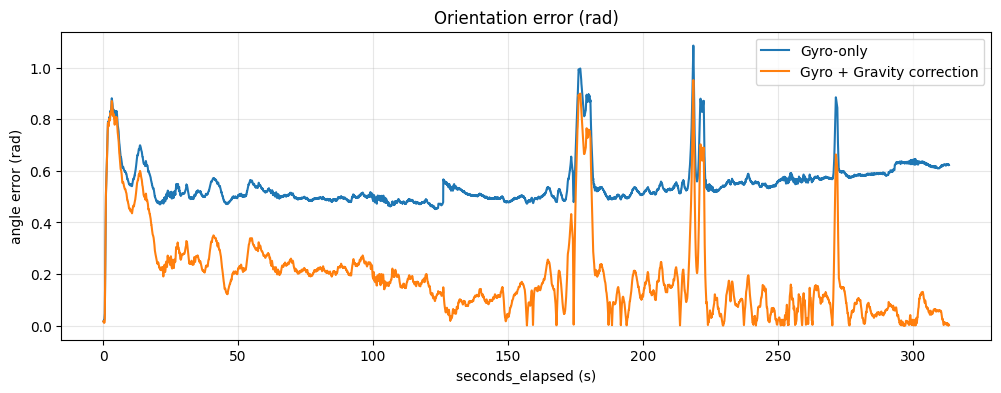

In [193]:
# -----------------------------
# 7) Plot
# -----------------------------
plt.figure(figsize=(12,4))
plt.title("Orientation error (rad)")
plt.xlabel("seconds_elapsed (s)")
plt.ylabel("angle error (rad)")

plt.plot(t_custom, angle_err_gyro, label="Gyro-only")
plt.plot(t_custom, angle_err_gyro_grav, label="Gyro + Gravity correction")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()